# 2. Develop roadmap construction methods

All the roadmap construction methods implemented in JAXMAPP are a subclass of `jaxmapp.roadmap.sampler.DefaultSampler`.

`DefaultSampler` has a method `construct_trms` that converts vertices and edges to a set of `TimedRoadmap`s. `TimedRoadmap` is a roadmap extended into the time direction (i.e., each vertex has its location + timestep) and used by our prioritized planning class to derive a solution. So, what you have to do to develop your own roadmap construction methods is essentially to implement your own .. 

- Vertex sampling function: `DefaultSampler.build_sample_vertices` that returns callable `sample_vertices` function that takes `key`, `num_samples`, and `instance` as input to provide vertices, and
- Edge connection check function: `DefaultSampler.build_check_connectivity` that returns `check_connectivity` that takes `vertices` and `instance` as input to return connectivity matrices.

Let's see how `RandomSampler` is implemented in `jaxmapp.roadmap.random_sampler.py`:


```python
@dataclass
class RandomSampler(DefaultSampler):
    """Random sampler"""

    def build_sample_vertices(self):
        if self.share_roadmap:
            return lambda key, num_samples, instance: jax.jit(
                sample_random_pos, static_argnames={"num_samples"}
            )(key, num_samples, instance.rads[0], instance.obs.sdf)
        else:

            def vmapped_fn(key, num_samples, instance):
                keys = jax.random.split(key, instance.num_agents)
                return jax.jit(
                    jax.vmap(sample_random_pos, in_axes=(0, None, 0, None)),
                    static_argnames={"num_samples"},
                )(keys, num_samples, instance.rads, instance.obs.sdf)

            return vmapped_fn

    def build_check_connectivity(self):
        if self.share_roadmap:
            return lambda vertices, instance: jax.jit(compute_linear_move_matrix)(
                vertices,
                instance.max_speeds[0],
                instance.rads[0],
                instance.obs.sdf,
            )
        else:
            return lambda vertices, instance: jax.jit(
                jax.vmap(compute_linear_move_matrix, in_axes=(0, 0, 0, None))
            )(
                vertices,
                instance.max_speeds,
                instance.rads,
                instance.obs.sdf,
            )
```

Note that there is an attribute named `share_roadmap`, which tells the sampler how roadmaps are constructed.

- If `share_roadmap == True`, all the agents will share the same roadmap while asssuming that they have the same `max_speed` (speed of agent) and `rad` (size of agent). For this case, `build_sample_vertices` should return a function that outputs vertices with the shape `(num_samples, 2)`.
- If `share_roadmap == False`, agents will be supposed to follow their own roadmap, which is useful when they each have different speed and size. For this case, the output should take the shape of `(num_agents, num_samples, 2)`.
- Likewise, `build_check_connectivity` should return a callable function that outputs a boolean connectivity matrix with the shape `(num_samples, num_samples)` when `share_roadmap == True` and `(num_agents, num_samples, num_samples` otherwise.
- You could simply implement these two versions separately, or if you are familiar with `jax.vmap`, you can vectorize the function used for the `share_roadmap == True` efficiently.

As a more practical example, let's implement an adaptive version of random sampler that limits sampling regions to be rectangles defined by the start and goal positions of agents.

In [1]:
import jax
import jax.numpy as jnp
from chex import dataclass

from jaxmapp.roadmap.sampler import DefaultSampler
from jaxmapp.utils.sampler import sample_random_pos
from jaxmapp.roadmap.utils import compute_linear_move_matrix

@dataclass
class AdaptiveRandomSampler(DefaultSampler):
    share_roadmap:bool = False
    
    def build_sample_vertices(self):
        def sample_vertices_from_rectangle(key, num_samples, rad, sdf, start, goal):
            """ Sample vertices from the rectanglar region defined by start and goal """
            
            vertices = sample_random_pos(key, num_samples, rad, jnp.ones(sdf.shape))
            start_goal = jnp.vstack((start, goal))
            top_left = start_goal.min(axis=0) * 0.9
            bottom_right = start_goal.max(axis=0) * 1.1
            return vertices * (bottom_right - top_left) + top_left
        
        if self.share_roadmap:
            raise NotImplementedError()
        else:
            keys = jax.random.split(key, ins.num_agents)
            vmapped_fn = jax.vmap(jax.jit(sample_vertices_from_rectangle, static_argnames={"num_samples"}), in_axes=(0, None, 0, None, 0, 0))
            return lambda key, num_samples, ins: vmapped_fn(keys, num_samples, ins.rads, ins.obs.sdf, ins.starts, ins.goals)
        
    def build_check_connectivity(self):
        """ Check if two vertices can be connected with a straight line shorter than max_speed without collisions with obstacles """
        if self.share_roadmap:
            raise NotImplementedError()
        else:
            return lambda vertices, instance: jax.jit(
                jax.vmap(compute_linear_move_matrix, in_axes=(0, 0, 0, None))
            )(
                vertices,
                instance.max_speeds,
                instance.rads,
                instance.obs.sdf,
            )

2022-02-02 15:12:06.907764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Note that although the implementation above is based on jax, you can essentially use any language as long as the input and output have the expected shape.

res_adaptive=Status: solved, makespan: 26.00, sum-of-costs: 193.00, sum-of-costs (normed): 19.30
res_random=Status: solved, makespan: 39.00, sum-of-costs: 252.00, sum-of-costs (normed): 25.20


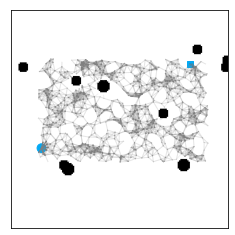

In [2]:
import jax 
from jaxmapp.env import InstanceGeneratorCircleObs
from jaxmapp.roadmap import RandomSampler
from jaxmapp.planner import PrioritizedPlanning
from jaxmapp.utils import viz

key = jax.random.PRNGKey(46)
generator = InstanceGeneratorCircleObs(num_agents_min=10, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)
ins = generator.generate(key)

# Aadaptive random sampler (with fewer vertices)
adaptive_sampler = AdaptiveRandomSampler(num_samples=800, max_T=64)
trms_adaptive = adaptive_sampler.construct_trms(key, ins)
viz.plot_trms(ins, trms_adaptive)

# Random sampler
random_sampler = RandomSampler(num_samples=1600, max_T=64, share_roadmap=True)
trms_random = random_sampler.construct_trms(key, ins)

planner = PrioritizedPlanning()
res_adaptive = planner.solve(ins.to_numpy(), trms_adaptive)
res_random = planner.solve(ins.to_numpy(), trms_random)
print(f"{res_adaptive=}")
print(f"{res_random=}")

## Advanced: Creating timed roadmaps from timed vertices and edges

`GridSampler` and `RandomSampler` both generate vertices and edges that are 'non-timed', i.e., they assume vertices and edges are fixed over timesteps.
In addition, `DefaultSampler` allows its subclasses to generate 'timed' vertices and edges that vary over timesteps, which is what `CTRMSampler` is doing.

To use timed vertices and edges, you have to:

- set `share_roadmap == False`
- set `timed_roadmap == True`
- define `build_sample_vertices` to return a callable function taking `key` and `instance` as input to provide timed vertices with the shape `(num_agents, max_T, num_samples, 2)` (where `max_T` is the maximum time steps)
- define `build_check_connectivity` to return a callable function taking `vertices` and `instance` as input to provide timed edges with the shape `(num_agents, max_T, num_samples, num_samples)`, where `edges[:, t, :, :]` describes the connectivity from `vertices[:, t]` to `vertices[:, t + 1]`.
  - If you are ok with checking connectivity while assuming agents to move linearly between two vertices, we would recommend you subclassing `CTRMSampler` as it provides an efficient implementation of such `check_connectivity` using jax.vmap.

In [3]:
import jax
import jax.numpy as jnp
from chex import dataclass

from jaxmapp.roadmap import CTRMSampler
from jaxmapp.utils.sampler import sample_random_pos
from jaxmapp.roadmap.utils import compute_linear_move_matrix

@dataclass
class AdaptiveTimedRandomSampler(CTRMSampler):
    share_roadmap:bool = False
    timed_roadmap:bool = True
    
    def build_sample_vertices(self):
        def _sample_timed_vertices_from_rectangle(key, num_samples, rad, sdf, start, goal, max_T, t):
            vertices = sample_random_pos(key, num_samples, rad, jnp.ones(sdf.shape))
            return (vertices - 0.5) * 0.1 + start + (t / max_T) * (goal - start)

        def sample_timed_vertices_from_rectangle(key, num_samples, rad, sdf, start, goal):
            vertices = jax.vmap(_sample_timed_vertices_from_rectangle, in_axes=(None, None, None, None, None, None, None, 0))(key, num_samples, rad, sdf, start, goal, self.max_T, jnp.arange(self.max_T))
            return vertices
        
        if self.share_roadmap:
            raise NotImplementedError()
        else:
            vmapped_fn = jax.vmap(jax.jit(sample_timed_vertices_from_rectangle, static_argnames={"num_samples"}), in_axes=(None, None, 0, None, 0, 0))
            return lambda key, num_samples, ins: vmapped_fn(key, num_samples, ins.rads, ins.obs.sdf, ins.starts, ins.goals)
        

In [4]:
adaptive_timed_sampler = AdaptiveTimedRandomSampler(num_samples=50, max_T=64)
trms_adaptive_timed = adaptive_timed_sampler.construct_trms(key, ins)
planner = PrioritizedPlanning()
res_adaptive_timed = planner.solve(ins.to_numpy(), trms_adaptive_timed)
print(f"{res_adaptive_timed=}")

res_adaptive_timed=Status: solved, makespan: 61.00, sum-of-costs: 553.00, sum-of-costs (normed): 55.30


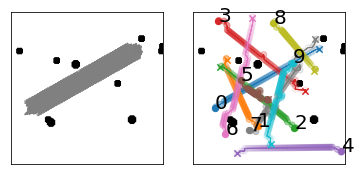

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
viz.plot_trms(ins, trms_adaptive_timed, is_timed=True, ax=axes[0])
viz.simple_plot_2d(ins, res_adaptive_timed, ax=axes[1])